In [1]:
import math
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


import torchvision
import pathlib
from pathlib import Path
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
!pip install split-folders[full] #installing split-folders for splitting data into train and validation sets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# always check your version
print(torch.__version__)

1.13.1+cu116


In [3]:
#device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [70]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = device):
    
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 1.1 Dataset class



In [4]:
#Importing the train data set from drive 
from google.colab import drive
drive.mount('/content/drive')
image_path =Path("/content/drive/MyDrive/train_set/train_set")

#creating the folder for spliting the data 
#train_path = "/content/drive/MyDrive/sets"
#Creating path if it does not exist or none is set
#os.makedirs(train_path, exist_ok=True) 



Mounted at /content/drive


In [ ]:
import splitfolders # or import splitfolders
input_folder = image_path
output = train_path #where you want the split datasets saved. 
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) #Test set 80% and validation set 20%

Copying files: 13520 files [05:10, 43.59 files/s]


In [5]:
train_dir = "/content/drive/MyDrive/sets/train"
val_dir = "/content/drive/MyDrive/sets/val"

In [6]:
#function to get class names and index
def class_names(directory):
  # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [137]:
classes,index = class_names(train_dir)

In [7]:
# Custom data set  
class image_dataset(Dataset):
  def __init__(self, directory,transforms=None):

    self.paths = list(pathlib.Path(directory).glob("*/*.JPEG"))
    self.transforms = transforms
    self.classes , self.class_to_idx = class_names(directory)
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, index):
    image_path = self.paths[index]
    img = Image.open(image_path).convert("RGB")
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    img = self.transforms(img)
    return img,class_idx

In [8]:
transform = transforms.ToTensor()
train_data_custom = image_dataset(train_dir, 
                                      transform)
val_data_custom = image_dataset(val_dir, 
                                     transform)

In [ ]:
#Checking the train and validation sets 
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(val_dir)

There are 30 directories and 0 images in '/content/drive/MyDrive/sets/val'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/redpanda'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/refrigerator'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/penguin'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/umbrella'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/pizza'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/mushroom'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/lion'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/pretzel'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/sombrero'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/pig'.
There are 0 directories and 90 images in '/content/drive/MyDrive/sets/val/ipod'.
The

In [9]:
from torch.utils.data import DataLoader
BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()
train_data_loader = DataLoader(train_data_custom,
                               BATCH_SIZE,
                               num_workers=2,
                               shuffle=True)

val_data_loader = DataLoader(val_data_custom,
                               BATCH_SIZE,
                               num_workers=2,
                               shuffle=False)

###  Defining a MLP model class 


In [ ]:
# define a MLP Model class
class mlp(nn.Module):
  def __init__(self,input_shape:int,
               output_shape:int):
    super().__init__()
    self.layerstack = nn.Sequential(
              nn.Flatten(),
              nn.Linear(input_shape , 1024),
              nn.ReLU(),
              nn.Linear(1024,512),
              nn.ReLU(),
              nn.Linear(512,256),
              nn.ReLU(),
              nn.Linear(256,output_shape),
              nn.LogSoftmax(dim=1)

                )
  def forward(self,j):
    return self.layerstack(j)

In [ ]:
model_mlp = mlp(3*64*64 , 30).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_mlp.parameters(), lr=0.01)


###  Defining a CNN model class


In [189]:

class CNN(nn.Module):
  
  def __init__(self,input,output):
    super().__init__()

    #coding cnn block (cnn,relu,pooling)
    self.block1 = nn.Sequential(
        nn.Conv2d(input,128,
                  kernel_size =5,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3),


        nn.Conv2d(128,256,
                  kernel_size =3,
                  stride=1,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3),
        
        nn.Conv2d(256,512,
                  kernel_size =3,
                  stride=2,
                  padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3),

    
         )
  
    
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*2*2, 256),
        nn.ReLU(),

        nn.Linear(256,output),
        nn.LogSoftmax(dim=1)

        
        
    )
    
  def forward(self,j):
    return self.linear(self.block1(j))
    

In [ ]:
model_cnn = CNN(3,30).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_cnn.parameters(), lr=0.01)


## Model training 



In [10]:
def accuracy_fn(y_true, y_pred):
  
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [11]:
def training(model,
             dataloader,
             loss_fn,
             optimizer,
             accuracy,
             ):
  
    train_loss = 0
    train_acc =0
    model.train()
    
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      

      loss = loss_fn(y_pred,y) 

      y_pred = torch.softmax(y_pred, dim=1)

      train_loss += loss.item()

      y_pred = torch.softmax(y_pred, dim=1)

      train_acc += accuracy( y_pred.argmax(dim=1),y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step() #updating once per batch instead of updating it at end of each epoch

      
    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)


    print(f"Train_loss :{train_loss:.5f} | Train_acc: {train_acc:.5f}")
    return (train_loss,train_acc)




In [12]:
def validation(model,
             dataloader,
             loss_fn,
             accuracy,
             ):
  
    test_loss = 0
    test_acc =0
    best_accuracy = 0
    model.eval()
    with torch.inference_mode():
      for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        test_pred = model(X)

        loss = loss_fn(test_pred,y)

        test_loss += loss.item()
        test_pred = torch.softmax(test_pred, dim=1)
        test_acc += accuracy(y, test_pred.argmax(dim=1))
      test_loss /= len(dataloader)
      test_acc /= len(dataloader)

      if test_acc > best_accuracy:
            path = "./myFirstModel_drop.pth"
            torch.save(model.state_dict(), path)
            best_accuracy = test_acc

      print(f"Test_loss :{test_loss:.5f} | Test_acc: {test_acc:.5f}")
      return (test_loss,test_acc)
    

In [71]:
def train(model, 
          train_data_loader: torch.utils.data.DataLoader, 
          val_data_loader: torch.utils.data.DataLoader, 
          loss_fn,
          optimizer,
          accuracy_fn,
          epochs: int):
  results = {"train_loss": [],
          "train_acc": [],
          "test_loss": [],
          "test_acc": [],
          "Epoch":[],
      }
  
  train_time_start_on_cpu = timer()

  for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch+1} \n ........")

    train_loss,train_acc = training(model,train_data_loader,loss_fn,optimizer,accuracy_fn)

    test_loss, test_acc = validation(model,val_data_loader,loss_fn,accuracy_fn)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    results["Epoch"].append(epoch)
  
  train_time_end_on_cpu = timer()
  total_train_time = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           )
  

  return results,total_train_time



In [ ]:
mlp_results = train(model_mlp, 
          train_data_loader, 
          val_data_loader, 
          loss_fn,
          optimizer,
          accuracy_fn,
          50) 

In [14]:
def plot(results,title):
  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(results["Epoch"], results["train_loss"], label='train_loss')
  plt.plot(results["Epoch"], results["test_loss"], label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(results["Epoch"], results["train_acc"], label='train_accuracy')
  plt.plot(results["Epoch"], results["test_acc"], label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend();

  plt.suptitle(title)
   

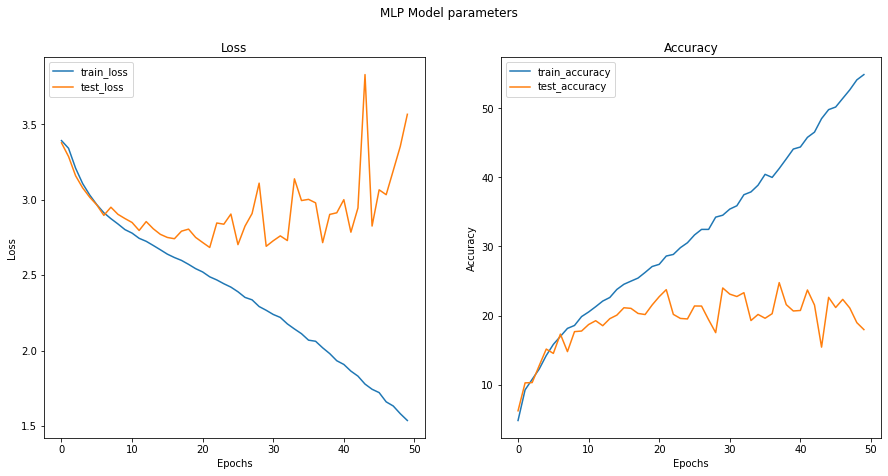

In [ ]:
plot(mlp_results,"MLP Model parameters")

In [ ]:
cnn_results = train(model_cnn, 
          train_data_loader, 
          val_data_loader, 
          loss_fn,
          optimizer,
          accuracy_fn,
          100) 

Train_loss :0.01897 | Train_acc: 99.86132
Test_loss :4.19662 | Test_acc: 41.74020
Epoch: 95 
 ........
Train_loss :0.01793 | Train_acc: 99.83358
Test_loss :4.22688 | Test_acc: 41.49510
Epoch: 96 
 ........
Train_loss :0.01898 | Train_acc: 99.84283
Test_loss :4.28725 | Test_acc: 41.70343
Epoch: 97 
 ........
Train_loss :0.47390 | Train_acc: 89.69120
Test_loss :4.00029 | Test_acc: 37.84314
Epoch: 98 
 ........
Train_loss :0.05389 | Train_acc: 99.35281
Test_loss :3.94379 | Test_acc: 40.98039
Epoch: 99 
 ........
Train_loss :0.02066 | Train_acc: 99.94453
Test_loss :4.08490 | Test_acc: 41.64216
Epoch: 100 
 ........
Train_loss :0.01547 | Train_acc: 99.95377
Test_loss :4.17062 | Test_acc: 40.88235


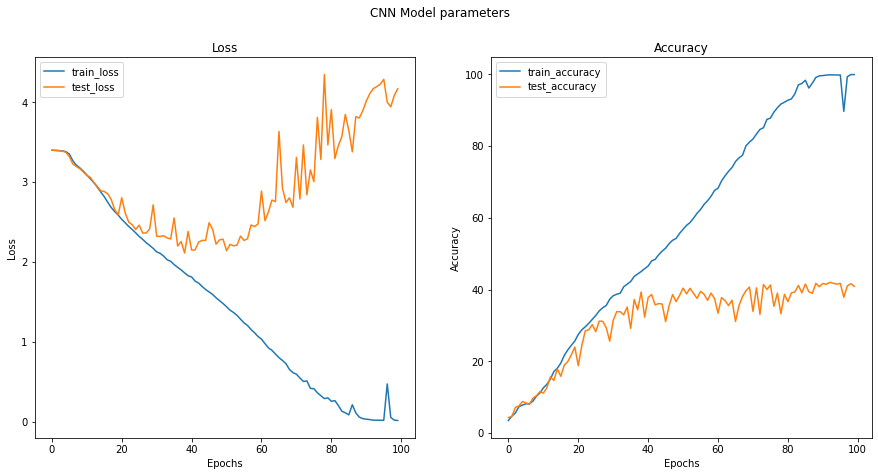

In [ ]:
plot(cnn_results,"CNN Model parameters")

### why CNN over MLP for image classification task?

*The two models MLP and CNN have used nn.Crossentropy as loss function and ReLU as non linear activation function and SGD as optimizer with lr = 0.01.*

*For MLP after flattening , we have one input layer , two Fully connected layers with inputs vectors of 1024 and 512 respectively and output layer followed by logsoftmax function for probabilities* 

*For CNN model ,we have 3 convolution layers with Relu and Maxpool2d layers for feature extraction and in classifier we flatten into a vector followed by 2 linear layers*.

*MLP takes vector as input i.e., (c,h,w) and CNN takes tensor as input i.e., colour channels in this case 3. so CNN can understand relation between pixels of images better*.

*This is evident from the loss curves of both and foundation cnn model has given 40% accuracy as compared to MLP's 20%.*
*In this we further do data agumentation,dropouts and Hyper parameter tuning this gave an accuracy around 61%. *

*So,for these reasons CNN is prefered over MLP* 

###  Generating confusion matrix 

In [153]:
def confusionmatrix(model_name,loader,title):
  from tqdm.auto import tqdm
  k=[]
  # 1. Make predictions with trained model
  y_preds = []
  model_name.eval()
  with torch.inference_mode():
    for X, y in tqdm(loader, desc="Making predictions"):
      # Send data and targets to target device
      X, y = X.to(device), y.to(device)
      k.append(y.cpu())
      # Do the forward pass
      y_logit = model_name(X)
      # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred.cpu())
      
  # Concatenate list of predictions into a tensor
  y_pred_tensor = torch.cat(y_preds)
  label = torch.cat(k)

  from sklearn.metrics import confusion_matrix
  import seaborn as sn
  import pandas as pd


  # Build confusion matrix
  cf_matrix = confusion_matrix(label, y_pred_tensor)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (25,25))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('output.png')
  plt.title(title)

Making predictions:   0%|          | 0/338 [00:00<?, ?it/s]

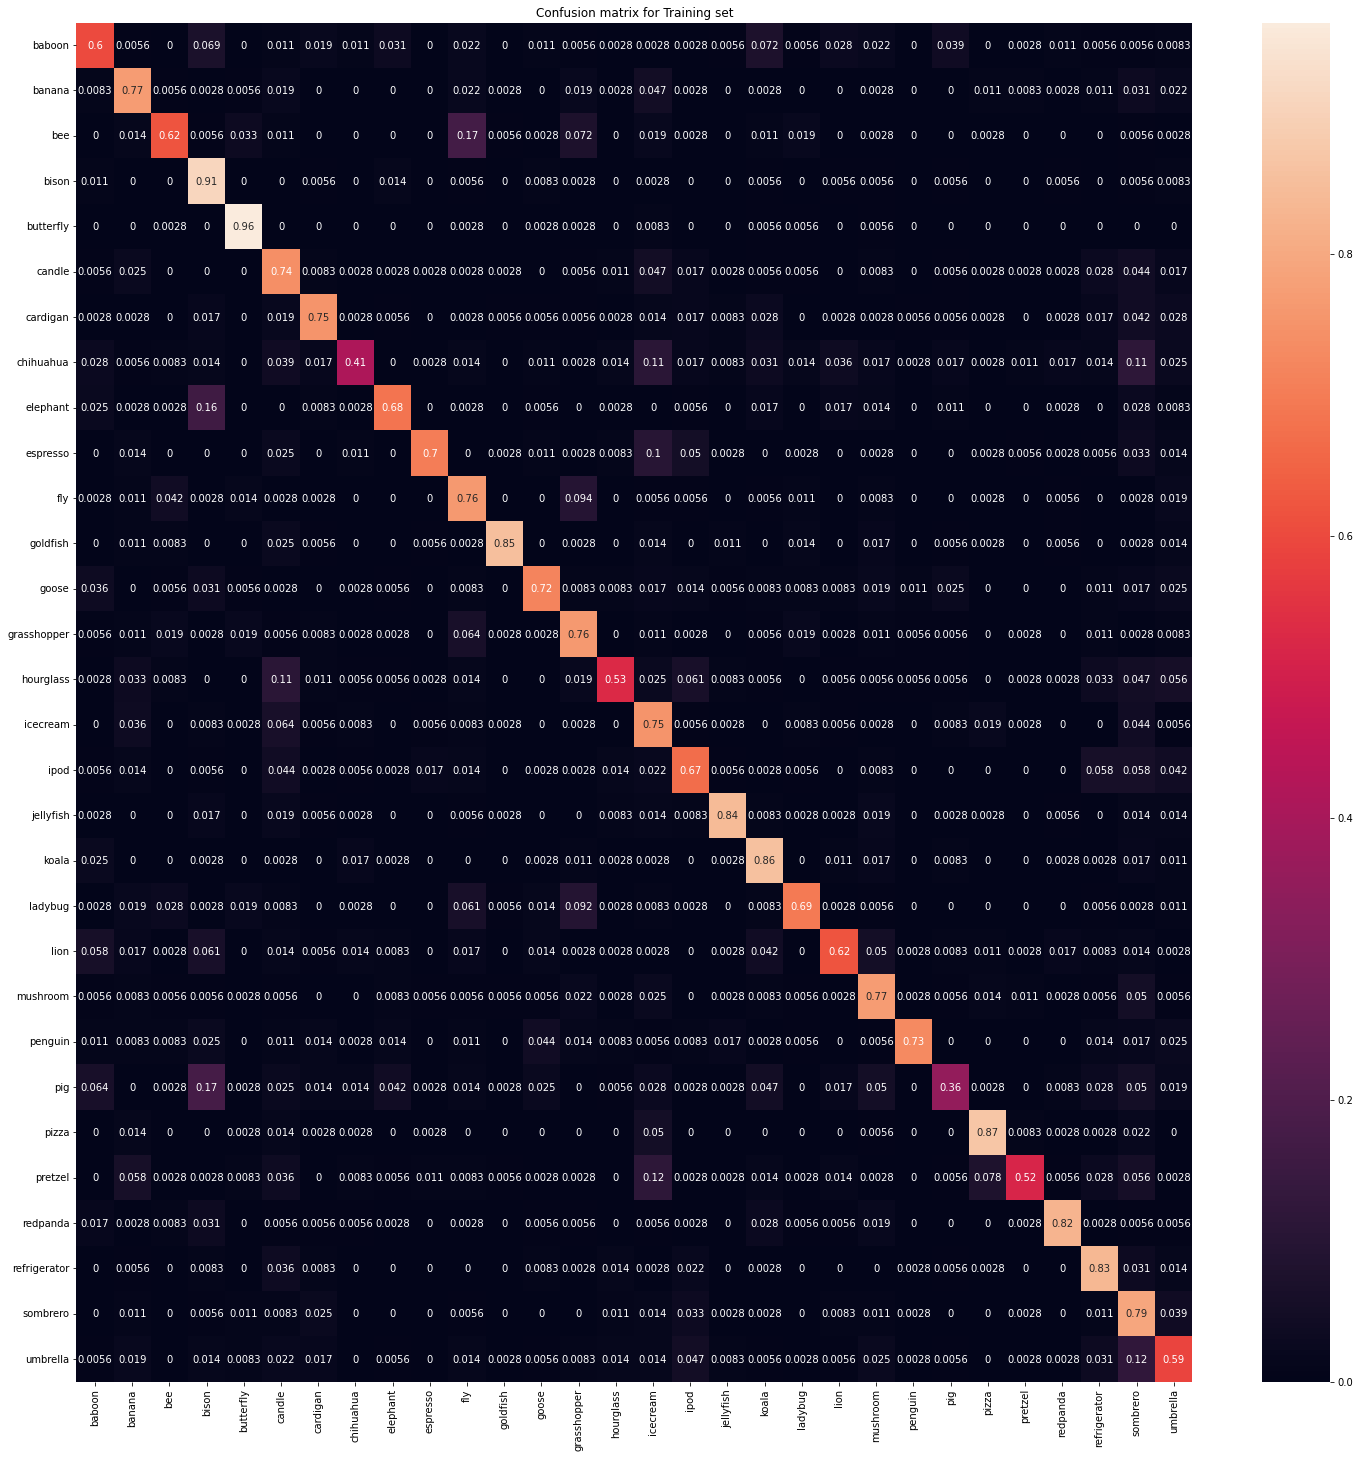

In [155]:
confusionmatrix(model_cnn_lr1,train_data_loader,"Confusion matrix for Training set")

Making predictions:   0%|          | 0/85 [00:00<?, ?it/s]

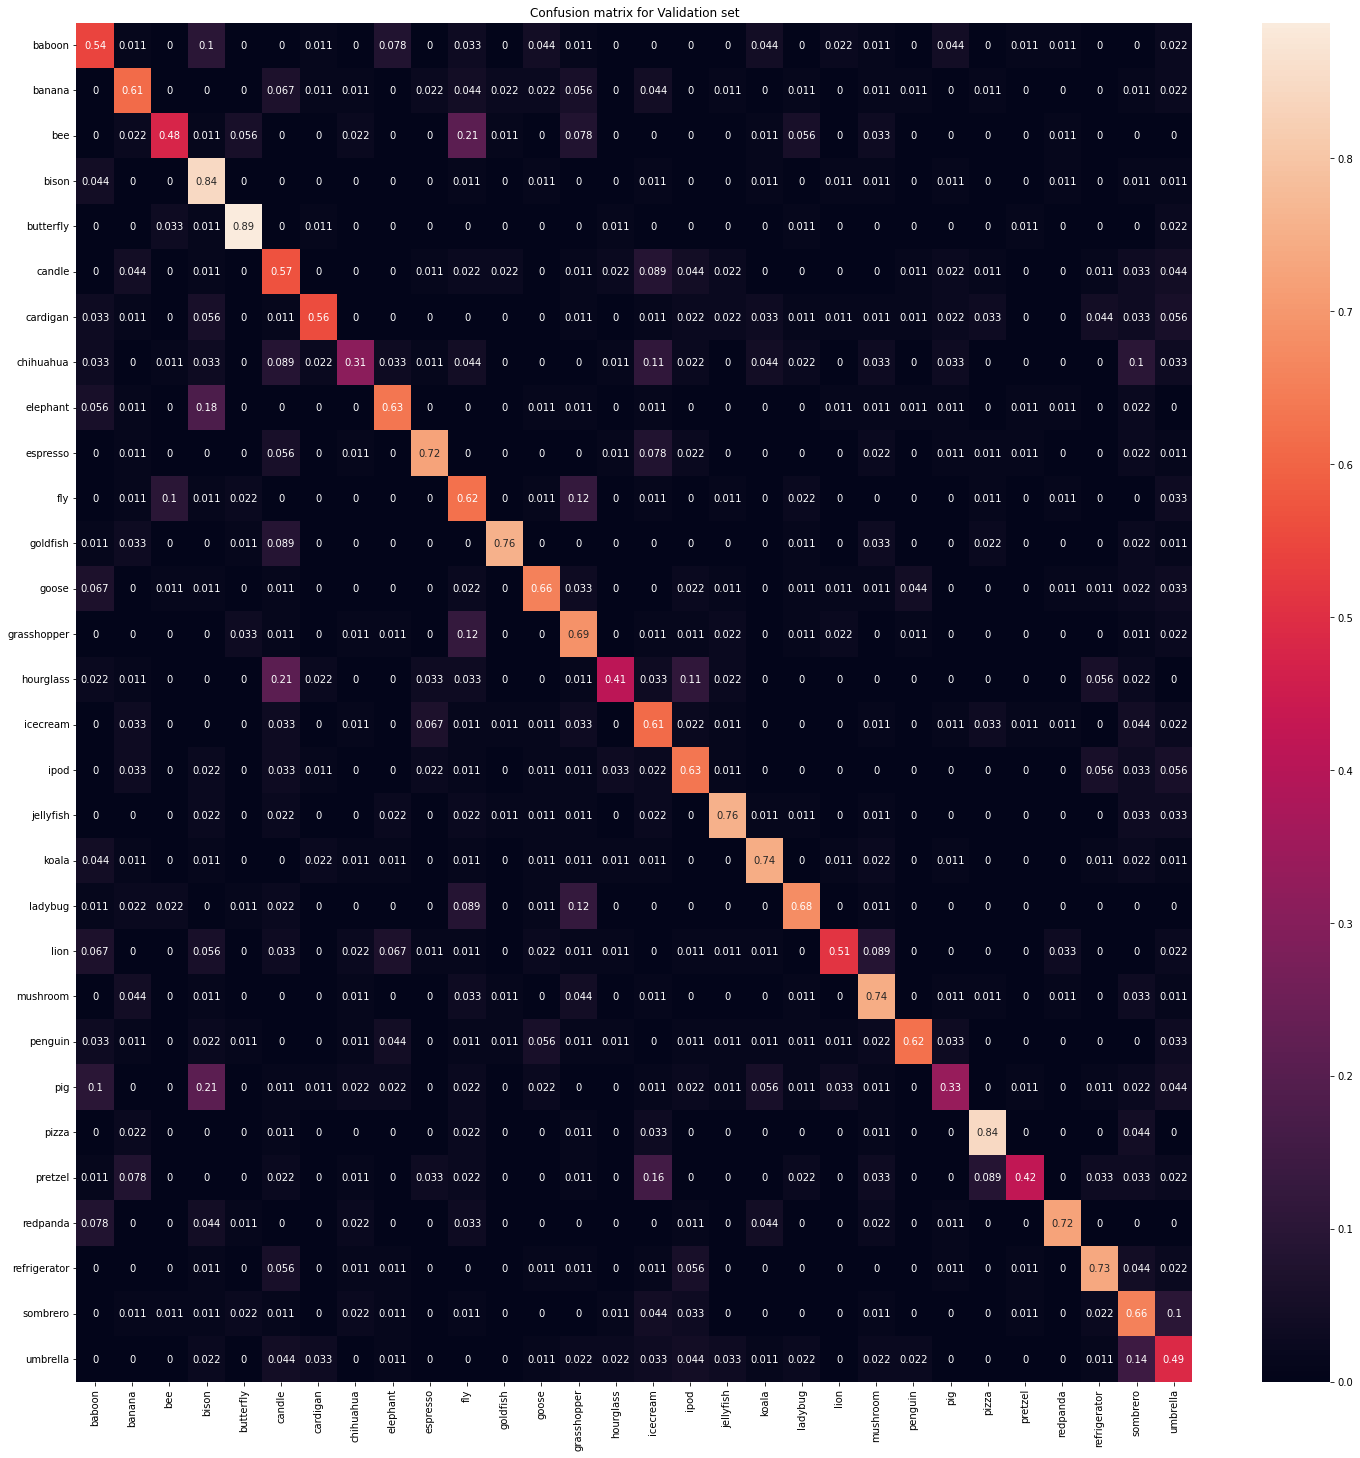

In [156]:
confusionmatrix(model_cnn_lr1,val_data_loader,"Confusion matrix for Validation set")


### Strategies for tackling overfitting


####  Data augmentation



Once data agumentaion techniques are applied the curve was smooth  as compared to foundation cnn model and the accuracy  increased upto 60%.
The overfitting was countered to some extent.


In [91]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    
 
    
    
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))     
])


train_data_custom = image_dataset(train_dir, 
                                      data_transform)
val_data_custom = image_dataset(val_dir, 
                                     val_transform)

from torch.utils.data import DataLoader
BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()
train_data_loader = DataLoader(train_data_custom,
                               BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               shuffle=True)

val_data_loader = DataLoader(val_data_custom,
                               BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               shuffle=False)


####  Dropout



I have opted for dropout = 0.25, As per "Analysis on the dropout effect in CNN" by Park and kwak "*If higher drop probability such as 0.5 is applied in convolutional layers, CNNs perform poor or cannot be trained at all*".The values of p in the range 0.1 to 0.2 showed less classfication error.

The graph for all the three techniques used is shown below.

In [110]:

class CNNv1(nn.Module):
  
  def __init__(self,input,output):
    super().__init__()

    #coding cnn block (cnn,relu,pooling)
    self.block1 = nn.Sequential(
        nn.Conv2d(input,128,
                  kernel_size =5,
                  stride=1,
                  padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3),
        #nn.Dropout(0.4) ,


        nn.Conv2d(128,256,
                  kernel_size =3,
                  stride=2,
                  padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3),
        #nn.Dropout(0.2),
        
        nn.Conv2d(256,512,
                  kernel_size =3,
                  stride=1,
                  padding=2),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3),
        

    
         )
  
    
    self.linear = nn.Sequential(
        nn.Dropout(0.25),
        nn.Flatten(),
        
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Linear(1024, output),
        
        nn.LogSoftmax(dim=1)

        
        
    )
    
  def forward(self,j):
    return self.linear(self.block1(j))
    

####  Hyperparameter tuning




In [111]:
model_cnn_lr1 = CNNv1(3,30).to(device)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_cnn_lr1.parameters(), lr=0.001)
cnn_results_lr1,time_lr1 = train(model_cnn_lr1, 
          train_data_loader, 
          val_data_loader, 
          loss_fn,
          optimizer,
          accuracy_fn,
          150) 

In [116]:
model_cnn_lr2 = CNNv1(3,30).to(device)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_cnn_lr2.parameters(), lr=0.0001)
cnn_results_lr2,time_lr2 = train(model_cnn_lr2, 
          train_data_loader, 
          val_data_loader, 
          loss_fn,
          optimizer,
          accuracy_fn,
          150) 

In [119]:
model_cnn_lr3 = CNNv1(3,30).to(device)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_cnn_lr3.parameters(), lr=0.1)
cnn_results_lr3,time_lr3 = train(model_cnn_lr3, 
          train_data_loader, 
          val_data_loader, 
          loss_fn,
          optimizer,
          accuracy_fn,
          100) 

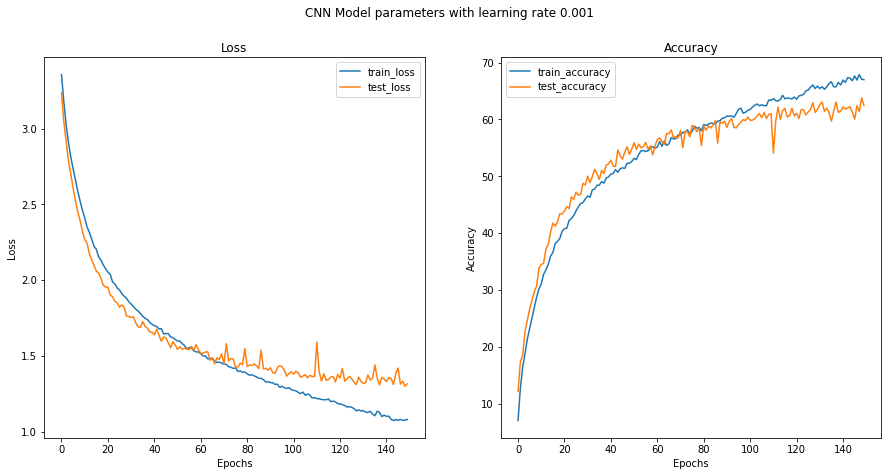

In [122]:
plot(cnn_results_lr1,"CNN Model parameters with learning rate 0.001")

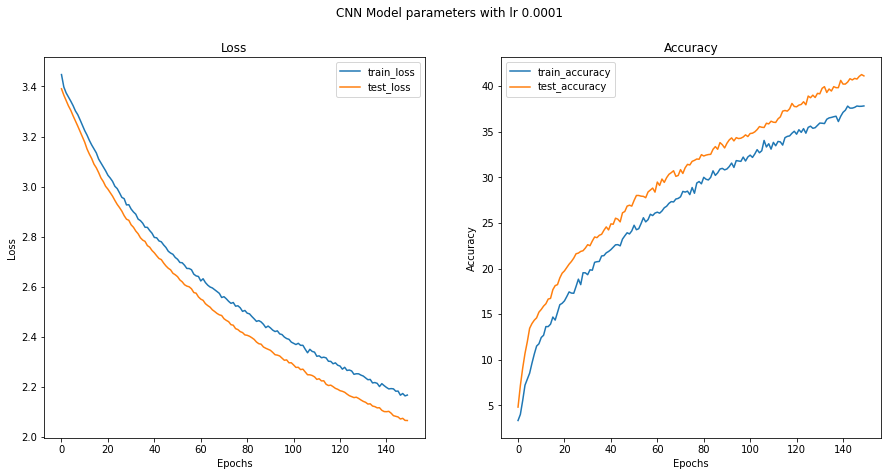

In [118]:
plot(cnn_results_lr2,"CNN Model parameters with learning rate 0.0001")

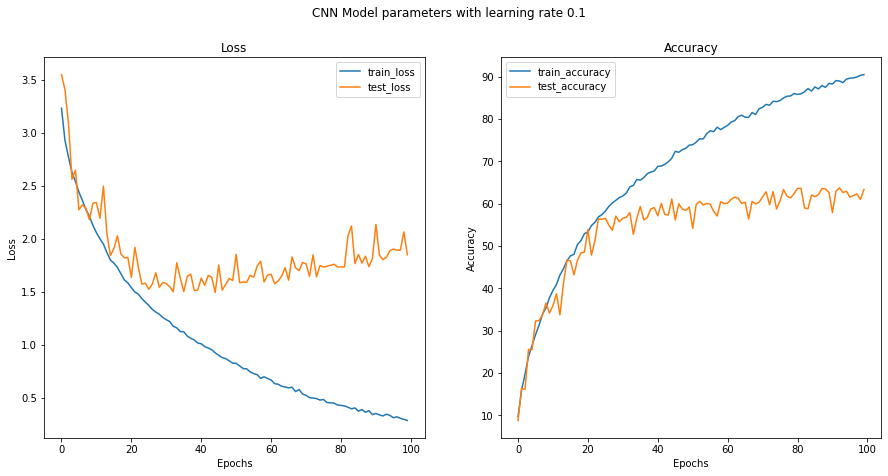

In [121]:
plot(cnn_results_lr3,"CNN Model parameters with learning rate 0.1")


### Model testing

In [15]:
test_path = "/content/drive/MyDrive/Test"

In [96]:

class test_dataset(Dataset):
  def __init__(self, directory,tf=None):


    self.paths = list(pathlib.Path(directory).glob("*/*.JPEG"))
    self.tf = tf

    self.classes , self.class_to_idx = class_names(directory)
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, index):
    image_path = self.paths[index]
    img = Image.open(image_path).convert("RGB")
    head, tail = os.path.split(image_path)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    img = self.tf(img)
    return img,tail 

In [97]:
train_data_custom1 = test_dataset(test_path, 
                                      tf=val_transform)

In [98]:
Test_data_loader = DataLoader(train_data_custom1,
                               1,
                               num_workers=NUM_WORKERS,
                               shuffle=False)

In [114]:
model = CNNv1(3,30).to(device)
model.load_state_dict(torch.load('/content/myFirstModel_drop.pth'))


<All keys matched successfully>

####  Saving predictions to Excel file 

In [115]:
import csv
# Define the path to the CSV file to save the results
csv_file = '/content/drive/MyDrive/mm22asg13.csv'
model.eval()
# Open the CSV file for writing
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Category'])

    # Loop over the images in the dataloader and make predictions
    for images, Id in Test_data_loader:
        # Move the images to the device
        images = images.to(device)

        # Make a prediction
        with torch.inference_mode():
            outputs = model(images)
            Category = torch.argmax(outputs, dim=1)

        # Write the image names and predictions to the CSV file
        for i in range(len(Id)):
            writer.writerow([Id[i], Category[i].item()])


In [ ]:
# 


###  Model Fine-tuning/transfer learning on CIFAR10 dataset  

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [16]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


In [17]:
device

'cuda'

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [19]:
train_data_custom = image_dataset(train_dir, 
                                      transform)
val_data_custom = image_dataset(val_dir, 
                                     transform)

from torch.utils.data import DataLoader
BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()
train_data_loader = DataLoader(train_data_custom,
                               BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=True)

val_data_loader = DataLoader(val_data_custom,
                               BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=False)


In [20]:
# Define the ratio of the dataset to be used for validation
val_ratio = 0.2
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(val_ratio * num_train))

# Shuffle the indices
np.random.shuffle(indices)

# Split the indices into training and validation sets
train_indices, val_indices = indices[split:], indices[:split]

# Define the data samplers for training and validation sets
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

# Define the data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                           sampler=train_sampler, num_workers = os.cpu_count()
)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                         sampler=val_sampler, num_workers = os.cpu_count()
)


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [185]:
alexnet = torchvision.models.AlexNet_Weights.DEFAULT
model = torchvision.models.alexnet(weights=alexnet)
model.to(device) #model parameters

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
num_classes = 10
model.classifier[6] = nn.Linear(4096, num_classes)


In [34]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [33]:
model.to(device) #model parameters for no frozen layers

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
model.to(device)
results_1 = train(model, 
          train_loader, 
          val_loader, 
          loss,
          optimizer,
          accuracy_fn,
          30)

In [ ]:
model.state_dict()

#### Fine-tuning model with frozen layers



In [186]:
for params in model.features.parameters():
  params.require_grad = False

In [187]:
model.classifier[4] = nn.Linear(4096, 2048).to(device)
model.classifier[6] = nn.Linear(2048, num_classes).to(device)

In [188]:
model#model features for frozen convolution block

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
results_2 = train(model, 
          train_loader, 
          val_loader, 
          loss,
          optimizer,
          accuracy_fn,
          30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 
 ........
Train_loss :0.44989 | Train_acc: 85.18870
Test_loss :0.33279 | Test_acc: 89.30973
Epoch: 2 
 ........
Train_loss :0.13371 | Train_acc: 95.71436
Test_loss :0.34990 | Test_acc: 89.68552
Epoch: 3 
 ........
Train_loss :0.08245 | Train_acc: 97.33177
Test_loss :0.35301 | Test_acc: 90.10087
Epoch: 4 
 ........
Train_loss :0.05617 | Train_acc: 98.21785
Test_loss :0.38500 | Test_acc: 90.06131
Epoch: 5 
 ........
Train_loss :0.04336 | Train_acc: 98.61472
Test_loss :0.35290 | Test_acc: 90.29866
Epoch: 6 
 ........
Train_loss :0.03361 | Train_acc: 98.94169
Test_loss :0.40401 | Test_acc: 89.86353
Epoch: 7 
 ........
Train_loss :0.02945 | Train_acc: 99.16134
Test_loss :0.40407 | Test_acc: 90.11076
Epoch: 8 
 ........
Train_loss :0.02271 | Train_acc: 99.35104
Test_loss :0.42271 | Test_acc: 90.18987
Epoch: 9 
 ........
Train_loss :0.02034 | Train_acc: 99.42093
Test_loss :0.39540 | Test_acc: 90.85245
Epoch: 10 
 ........
Train_loss :0.01756 | Train_acc: 99.50579
Test_loss :0.39455 

####  Comparing above configurations and comment on comparative performance

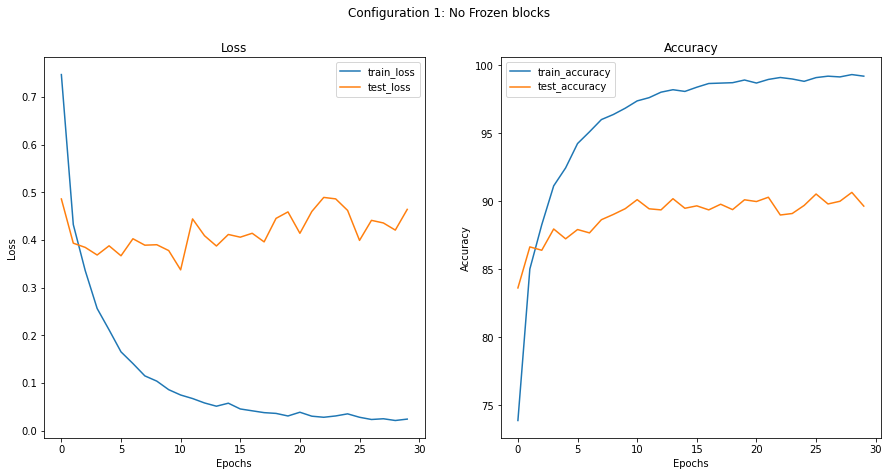

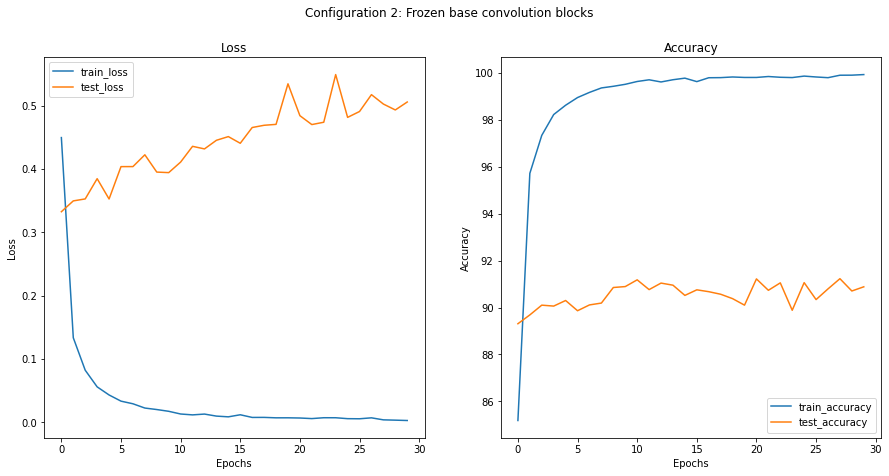

In [143]:
# Your graphs here and please provide comment in markdown in another cell
plot(results_1,"Configuration 1: No Frozen blocks")
plot(results_2,"Configuration 2: Frozen base convolution blocks")

###  Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

####  Finetuning AlexNet on TinyImageNet30


In [60]:
alexnet = torchvision.models.AlexNet_Weights.DEFAULT
model_v1 = torchvision.models.alexnet(weights=alexnet)


In [61]:
for params in model_v1.features.parameters():
  params.require_grad = False

In [162]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_v1.parameters(), lr=0.001)

In [163]:
num_classes=30

In [164]:
model_v1.classifier[4] = nn.Linear(4096, 2048).to(device)
model_v1.classifier[6] = nn.Linear(2048, num_classes).to(device)

In [165]:
model_v1.to(device) # model parameters

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
results_12,time_12 = train(model_v1, 
          train_data_loader, 
          val_data_loader, 
          loss,
          optimizer,
          accuracy_fn,
          50)

#### Comparing results on validation set of TinyImageNet30


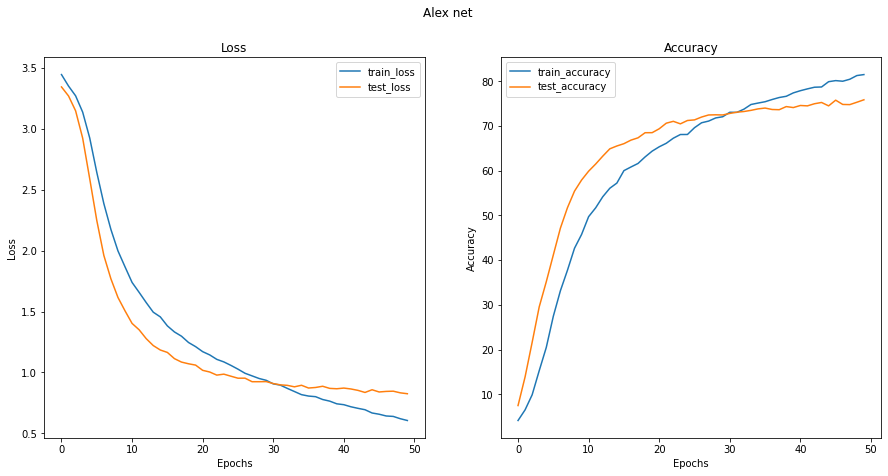

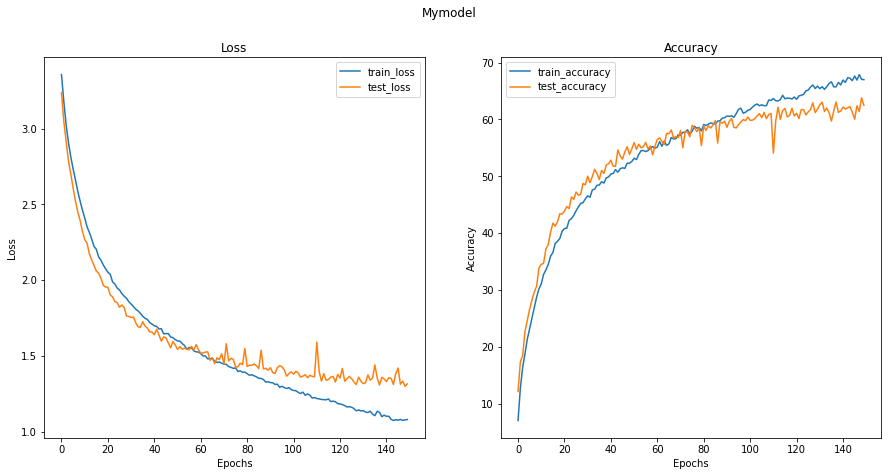

In [142]:
# Your code here! 
plot(results_12,"Alex net ")
plot(cnn_results_lr1,"Mymodel")

In [182]:
print(" My model Execution time:", time_lr1, "seconds")
print("\n Alex net Execution time:", time_12, "seconds")

 My model Execution time: 2803.850115657 seconds

 Alex net Execution time: 935.2385233719979 seconds


Making predictions:   0%|          | 0/85 [00:00<?, ?it/s]

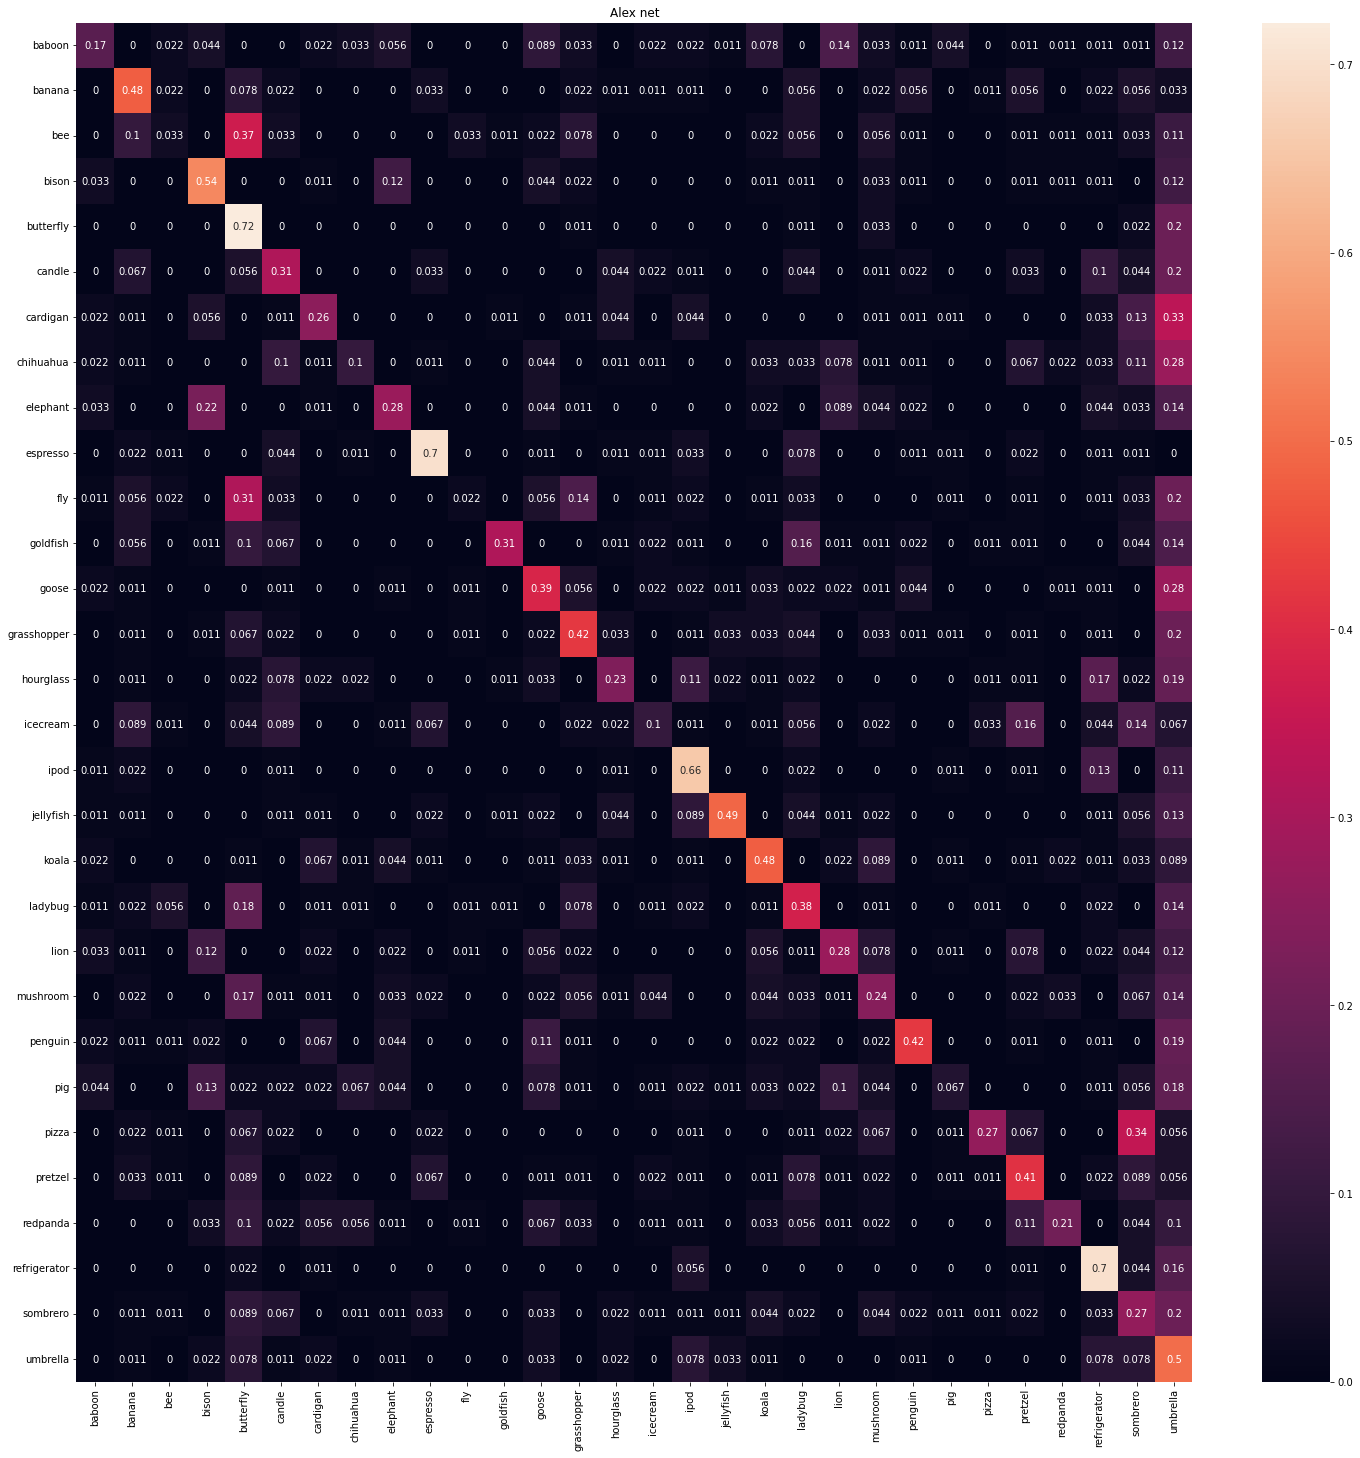

In [157]:
confusionmatrix(model_v1,val_data_loader,"Alex net")

Making predictions:   0%|          | 0/85 [00:00<?, ?it/s]

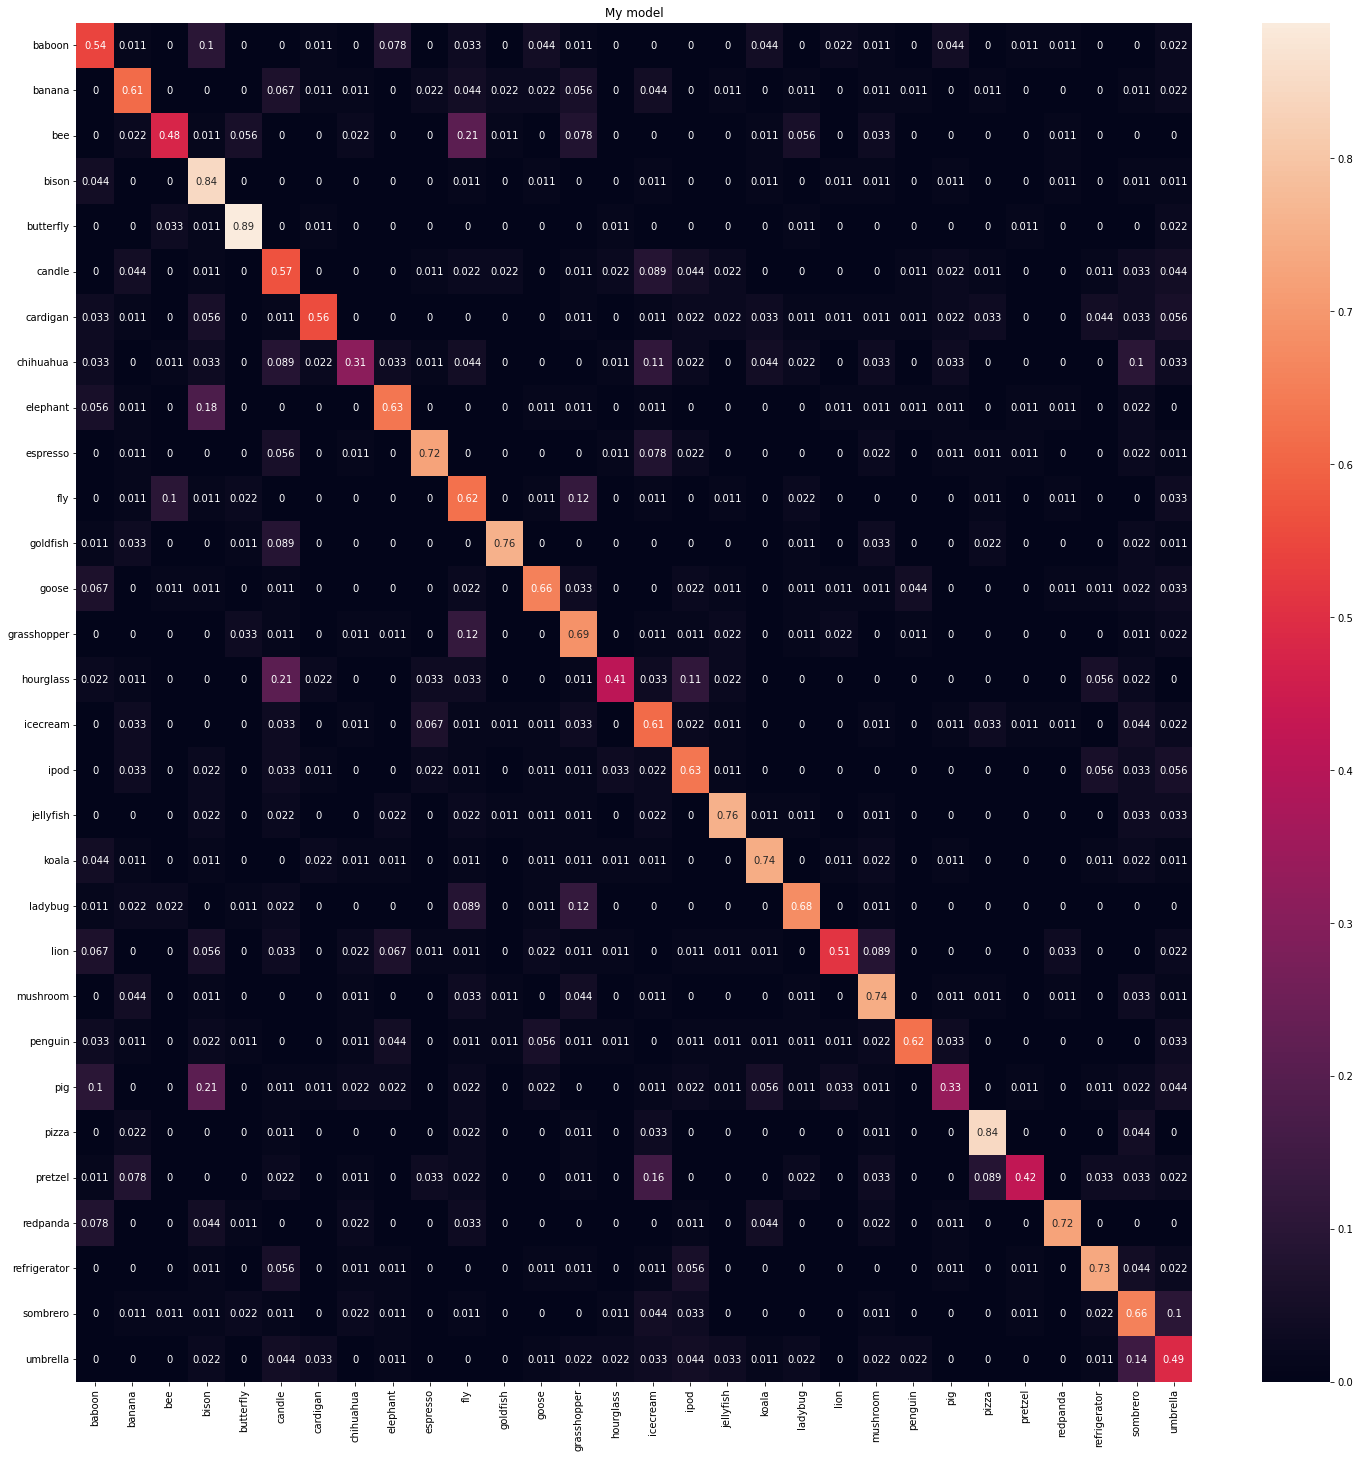

In [159]:
confusionmatrix(model_cnn_lr1,val_data_loader,"My model")